**DUDAS:**

* 4.0 Armado del conjunto de entrenamiento y de prueba: no sé cómo utilizar **stratified sampling**
* 4.0/4.1 para vecinos cercanos utilizo Ap y QBO o puedo utilizar los clusters
* Cómo saber si el conjunto está overfitting o underfitting? intenté con el accuracy pero no me convencen los resultados al compararlos con la matriz de confusión.
https://www.aprendemachinelearning.com/sets-de-entrenamiento-test-validacion-cruzada/
Aquí dice q tengo q usar una métrica (usa accuracy) para ver si el modelo es el adecuado para mis datos. Si obtengo un valor cercano a 75%, el modelo ajusta bien con mis datos, si es mucho más o mucho menos, el modelo puede estar en overfitting o underfitting.
* Ver la parte de métricas al final de vecinos cercanos
Tengo desbalanseados los datos?

Repito rápidamente lo realizado en la notebook anterior para tener los datos y clusters ya encontrados y poder utilizarlos en el aprendizaje supervisado.

⚛Saltar a **4. Apredizaje Supervisado**


# **2. Base de datos**

Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
base = "Base de datos corregida.xlsx"
# datos = pd.read_excel(base,index_col=0, parse_dates=True)   #IMORTATE:ES ARA SERIES DE DATOS
datos = pd.read_excel(base)

**Nuevas bases de datos:**

In [ ]:
# Primero separo las columnas que voy a estudiar y los meses de invierno(DEFM):
enero2=datos.loc[datos["MM"]==1,["YY","MM","Ap",'30hP QBO',"NAO(C)"]]
febrero2=datos.loc[datos["MM"]==2,["YY","MM","Ap",'30hP QBO', "NAO(C)"]]
marzo2=datos.loc[datos["MM"]==3,["YY","MM","Ap",'30hP QBO', "NAO(C)"]]
diciembre2=datos.loc[datos["MM"]==12,["YY","MM","Ap",'30hP QBO',"NAO(C)"]]

# Ahora quiero sacar los promedios de los meses de invierno pero tengo que cuidar de promediar el mes de Diciembre de un año con los de Enero-Febrero-Marzo del siguiente
diciembre3=diciembre2  #para no modificar diciembre2 (quizas analizo cada mes después)
diciembre3_array=diciembre3.to_numpy()
#hago matriz con 1 en yy y 0 en el resto
a=np.zeros((68, 5))
a[:,0]=1
#Ahora sumo la matriz a con la de diciembre para que cada elemento de YY ahora sea YY+1
diciembre3_array1=diciembre3_array + a
#paso a dataframe
diciembre4=pd.DataFrame(diciembre3_array1,columns = ['YY', 'MM', 'Ap','30hP QBO', 'NAO(C)'])

#Junto todos los meses de invierno
meses_invierno=pd.concat([diciembre4,enero2,febrero2,marzo2],ignore_index=True)

# Ahora si saco los promedios de los meses de invierno

#quiero el número de veces que hace falta sacar el promedio, lo hago sabiendo la cantidad de años:
m=meses_invierno["YY"].min()
m2=meses_invierno["YY"].max()
n=int(m2-m)
# print(n) #68

invierno00=np.zeros((n,5))

for i in range(0,n):
  year=meses_invierno.loc[meses_invierno["YY"]==m+i,:]
  prom=year.mean()
  invierno00[i:]=year.mean()

#paso a dataframe
invierno00=pd.DataFrame(invierno00,columns = ['YY', 'MM', 'Ap','30hP QBO', 'NAO(C)'])

#descarto 1953 ya que no tengo dato de diciembre del 92 y saco MM
invierno0= invierno00.drop([0],axis=0)
invierno=invierno0.drop(columns=['MM'])

Normalización

In [ ]:
invierno_sin_normalizar = invierno.copy()  #para tener una copia sin normalizar x las dudas

column = ("YY", 'Ap', "30hP QBO", "NAO(C)")

for i in range(0,3):
  invierno[column[i]] = invierno[column[i]] /invierno[column[i]].abs().max()

display(invierno)

,YY,Ap,30hP QBO,NAO(C)
1,0.967327,0.545455,-0.422985,0.1325
2,0.967822,0.500000,0.313647,-1.2100
3,0.968317,0.693182,-0.109338,-0.8000
4,0.968812,0.795455,-0.020750,1.6500
5,0.969307,0.977273,0.204310,-0.2650
...,...,...,...,...
63,0.998020,0.501441,0.243416,1.8325
64,0.998515,0.484172,0.540303,1.1750
65,0.999010,0.309005,-0.908220,0.4000
66,0.999505,0.282101,0.462091,1.4650


***

#**3. Aprendizaje no Supervisado:** Clusterización

## K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [ ]:
X=invierno.drop(columns=['YY'])

n_Clusters = 2

In [ ]:
num_clusters = 2                                #  Puedo cambiar rápidamente el número de clusters desde aquí
kmeans = KMeans(n_clusters=num_clusters).fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
invierno_solo=invierno.copy()
invierno['clusters_km2']=kmeans.labels_
invierno.head()

,YY,Ap,30hP QBO,NAO(C),clusters_km2
1,0.967327,0.545455,-0.422985,0.1325,1
2,0.967822,0.500000,0.313647,-1.2100,1
3,0.968317,0.693182,-0.109338,-0.8000,1
4,0.968812,0.795455,-0.020750,1.6500,0
5,0.969307,0.977273,0.204310,-0.2650,1


## MeanShift

In [ ]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
ms = MeanShift(bandwidth=0.64, bin_seeding=False) #bin_seeding=True usa versión discretizada de los puntos en una
# cuadrícula que tiene que ver con el ancho de banda, agiliza el algoritmo
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

invierno['clusters_MS']=ms.labels_
invierno.head()

,YY,Ap,30hP QBO,NAO(C),clusters_km2,clusters_MS
1,0.967327,0.545455,-0.422985,0.1325,1,4
2,0.967822,0.500000,0.313647,-1.2100,1,2
3,0.968317,0.693182,-0.109338,-0.8000,1,2
4,0.968812,0.795455,-0.020750,1.6500,0,1
5,0.969307,0.977273,0.204310,-0.2650,1,0


## DBSCAN

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
# from sklearn import preprocessing
# from sklearn.metrics import silhouette_score
from collections import Counter

In [ ]:
min_samples = X.shape[1]+1 #  Rule of thumb: min_samples ≥ D + 1
dbscan2 = DBSCAN(eps=0.29, min_samples=min_samples).fit(X) # se define y ajusta (fitea) el modelo

In [ ]:
df_clustersDB=X.copy()
invierno['clusters_DB']=dbscan2.labels_

print('cantidad de datos por cluster: ',Counter(dbscan2.labels_))
invierno.head()

cantidad de datos por cluster:  Counter({-1: 56, 1: 6, 0: 5})


,YY,Ap,30hP QBO,NAO(C),clusters_km2,clusters_MS,clusters_DB
1,0.967327,0.545455,-0.422985,0.1325,1,4,-1
2,0.967822,0.500000,0.313647,-1.2100,1,2,-1
3,0.968317,0.693182,-0.109338,-0.8000,1,2,0
4,0.968812,0.795455,-0.020750,1.6500,0,1,-1
5,0.969307,0.977273,0.204310,-0.2650,1,0,-1


Visualizo los clusters

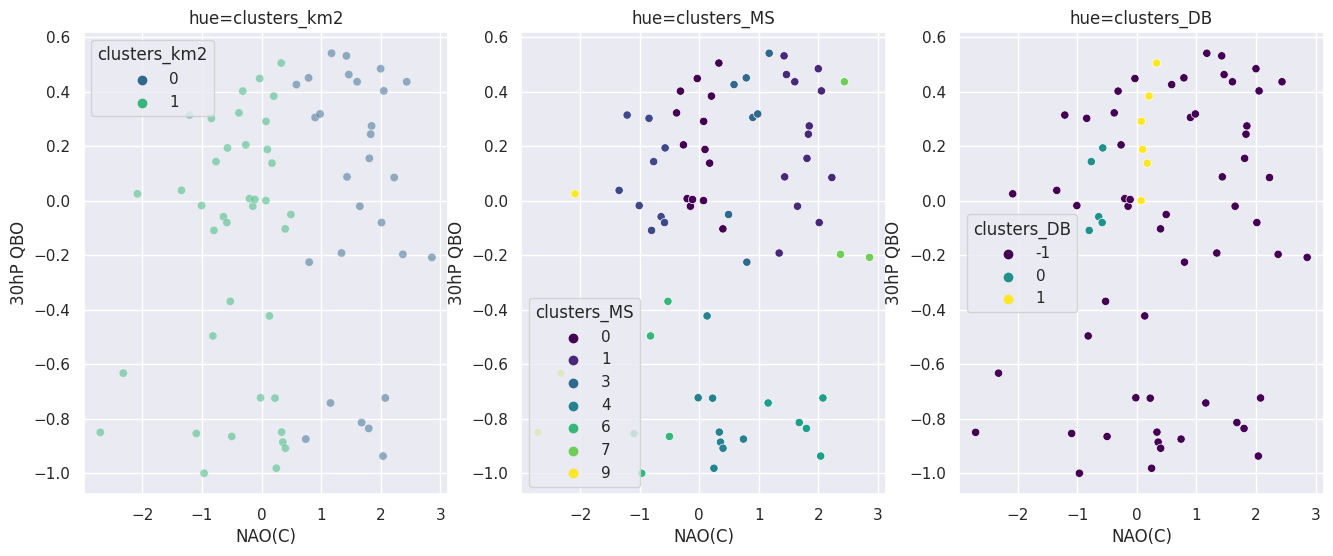

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(131), sns.scatterplot(data=invierno, x="NAO(C)", y="30hP QBO" , hue="clusters_km2", palette="viridis" , alpha=0.5), plt.title('hue=clusters_km2')
plt.subplot(132), sns.scatterplot(data=invierno,  x="NAO(C)", y="30hP QBO",palette="viridis", hue="clusters_MS"), plt.title('hue=clusters_MS')
plt.subplot(133), sns.scatterplot(data=invierno,  x="NAO(C)", y="30hP QBO",palette="viridis", hue="clusters_DB"), plt.title('hue=clusters_DB')
plt.show()

#**4. Aprendizaje Supervisado**:

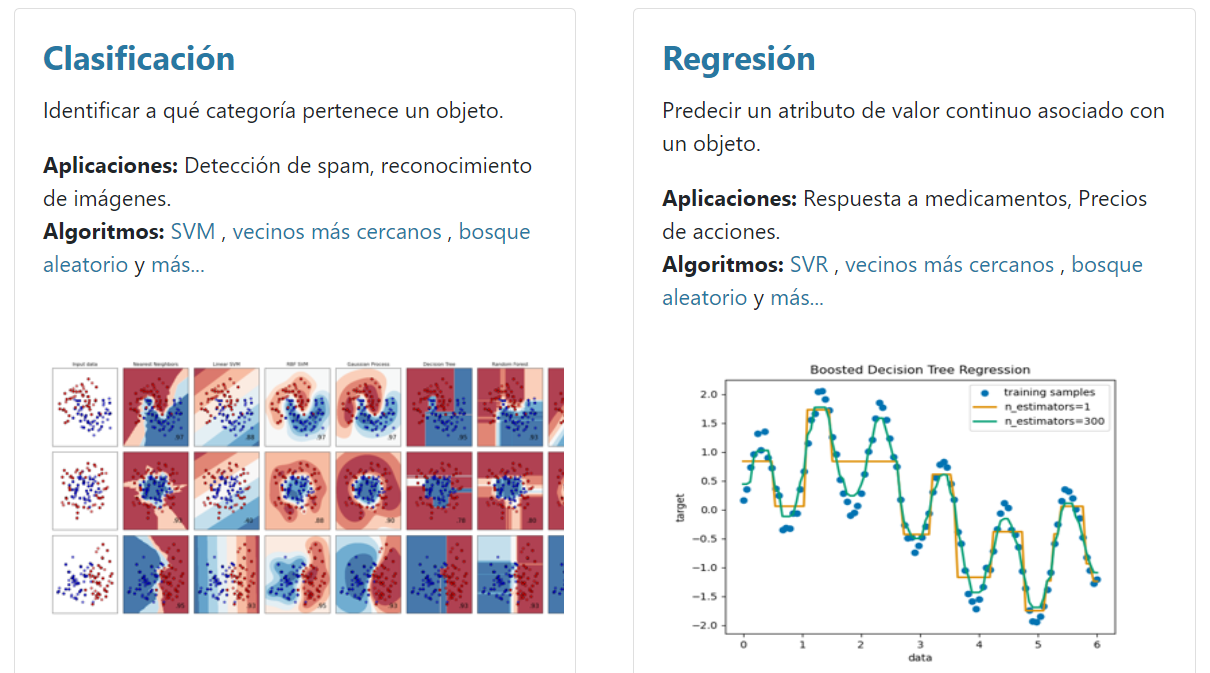

**Métodos/Algoritmos:**


• Vecinos cercanos.

• Clasificador bayesiano.

• Árboles de decisión y bosques aleatorios.

• Máquinas de soporte vectorial.

• Regresión lineal.

• Regresión logística.

• Redes neuronales.

https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

## 4.0. Discretizo la variable NAO

En mi caso, al tener datos contínuos, debería hacer una regresión pero al solo importarme el sigo de la NAO me dedico a hacer clasificación. Discretizo mis datos de la NAO con 0s y 1s dependiendo si es positivo o negativo el índice respectivamente.

In [ ]:
invierno_NAOcont=invierno.copy()

#creo nueva columna con booleanos
invierno['fase NAO']= invierno['NAO(C)'] < 0   #CONDICION False-posittivo, True-negativo
# invierno_qbo.head()

#paso a 0s y 1s

# 1ra opción
fase={False:0, True:1}      #CONDICION False-posittivo-0, True-negativo-1
invierno['fase NAO']=invierno['fase NAO'].map(fase)

# 2da opción
# invierno_NAO['fase NAO']=invierno_NAO['fase NAO'].replace(["False", "True"], [0,1])   #no sale con esta

# invierno_NAO        #comprobar que las condiciones (False-posittivo-0, True-negativo-1) se cumplen
#saco la columna NAO(C)
# invierno_NAO=invierno_NAO.drop(columns=['NAO(C)'])
invierno

,YY,Ap,30hP QBO,NAO(C),clusters_km2,clusters_MS,clusters_DB,fase NAO
1,0.967327,0.545455,-0.422985,0.1325,1,4,-1,0
2,0.967822,0.500000,0.313647,-1.2100,1,2,-1,1
3,0.968317,0.693182,-0.109338,-0.8000,1,2,0,1
4,0.968812,0.795455,-0.020750,1.6500,0,1,-1,0
5,0.969307,0.977273,0.204310,-0.2650,1,0,-1,1
...,...,...,...,...,...,...,...,...
63,0.998020,0.501441,0.243416,1.8325,0,1,-1,0
64,0.998515,0.484172,0.540303,1.1750,0,3,-1,0
65,0.999010,0.309005,-0.908220,0.4000,1,4,-1,0
66,0.999505,0.282101,0.462091,1.4650,0,1,-1,0


In [ ]:
# invierno_NAO["fase NAO"].sum()  #la suma me da la cantidad de 1 (fases positivas de la NAO)

<Axes: xlabel='fase NAO', ylabel='count'>

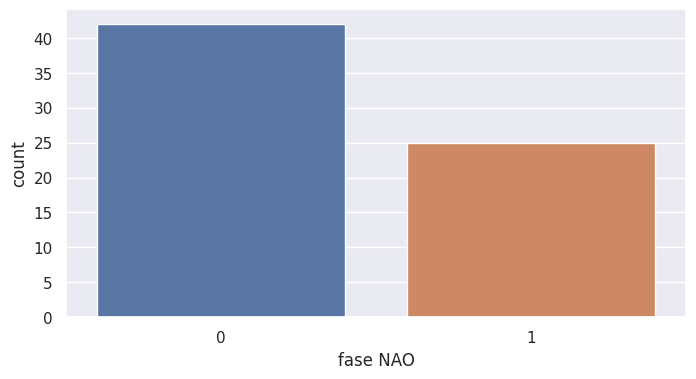

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (8, 4))
sns.countplot(x = 'fase NAO', data=invierno)

Hay un número muy desparejo de fases NAO, con 25 datos de NAO - y 42 NAO +

Debo tener esto en cuenta al momento de armar el conjunto de entrenamiento y prueba

## 4.0. Armado del conjunto de entrenamiento y de prueba

Entreno con el 75% y pruebo con el 25% (aquí decide la función)

In [ ]:
invierno.info()     #para saber los números de las columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 1 to 67
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YY            67 non-null     float64
 1   Ap            67 non-null     float64
 2   30hP QBO      67 non-null     float64
 3   NAO(C)        67 non-null     float64
 4   clusters_km2  67 non-null     int32  
 5   clusters_MS   67 non-null     int64  
 6   clusters_DB   67 non-null     int64  
 7   fase NAO      67 non-null     int64  
dtypes: float64(4), int32(1), int64(3)
memory usage: 4.1 KB


In [ ]:
X = invierno.iloc[:, [1,6]].values  #  La idea es probar con los clusters o con la QBO, además del índice de act geomagnética Ap
#opciones: [1,2] o [1,4] o [1,5] 0 [1,6]
y = invierno.iloc[:, 7].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print("Todo el conjunto:", len(y)- y.sum(),"NAO+ / ", y.sum(),"NAO-")
print("Conjunto entrenamiento:", len(y_train)- y_train.sum(),"NAO+ / ", y_train.sum(),"NAO-")
print("Conjunto prueba:", len(y_test)- y_test.sum(),"NAO+ / ", y_test.sum(),"NAO-")

Todo el conjunto: 42 NAO+ /  25 NAO-
Conjunto entrenamiento: 31 NAO+ /  19 NAO-
Conjunto prueba: 11 NAO+ /  6 NAO-


Aquí tuve que tener cuidado con la distribución de datos NAO + y -

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [ ]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

## 4.1. Vecinos Cercanos

In [ ]:
#Vecinos cercanos
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

#Matriz de confusión y Métricas
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import StratifiedKFold, KFold

Accuracy en el conjunto de entrenamiento: 0.92
Metricas cross_validation [0.5   0.625 0.875 0.5   0.625]
Media de cross_validation 0.625
N° Vecinos Cercanos 2


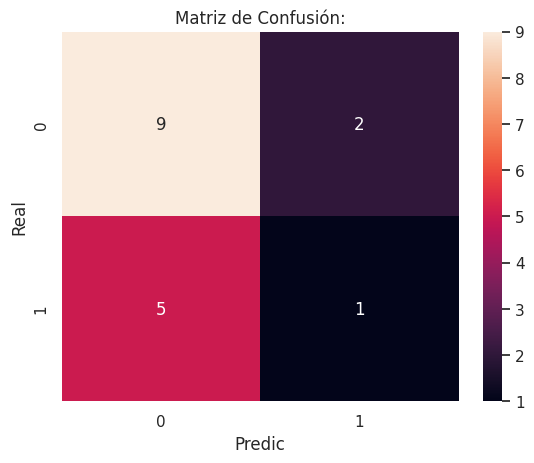

              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.33      0.17      0.22         6

    accuracy                           0.59        17
   macro avg       0.49      0.49      0.47        17
weighted avg       0.53      0.59      0.54        17

 
 
Accuracy en el conjunto de entrenamiento: 0.92
Metricas cross_validation [0.875 0.625 0.875 0.625 0.75 ]
Media de cross_validation 0.75
N° Vecinos Cercanos 3


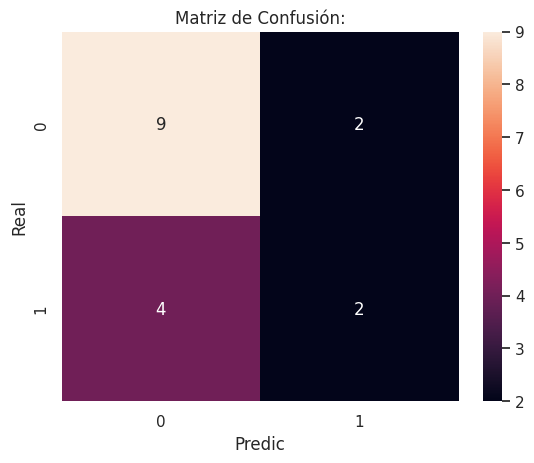

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.50      0.33      0.40         6

    accuracy                           0.65        17
   macro avg       0.60      0.58      0.58        17
weighted avg       0.62      0.65      0.63        17

 
 
Accuracy en el conjunto de entrenamiento: 0.92
Metricas cross_validation [0.75  0.625 0.875 0.625 0.625]
Media de cross_validation 0.7
N° Vecinos Cercanos 4


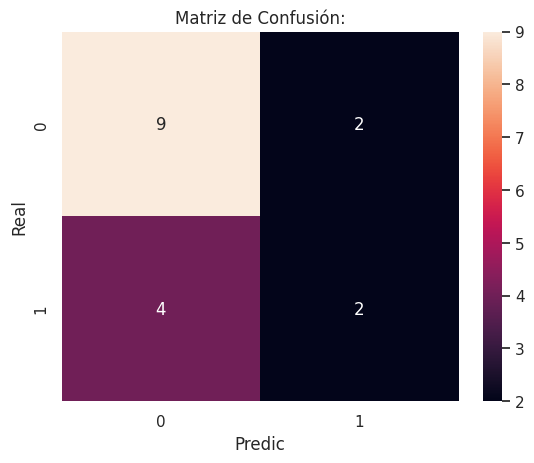

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.50      0.33      0.40         6

    accuracy                           0.65        17
   macro avg       0.60      0.58      0.58        17
weighted avg       0.62      0.65      0.63        17

 
 
Accuracy en el conjunto de entrenamiento: 0.92
Metricas cross_validation [0.875 0.625 0.75  0.625 0.75 ]
Media de cross_validation 0.725
N° Vecinos Cercanos 5


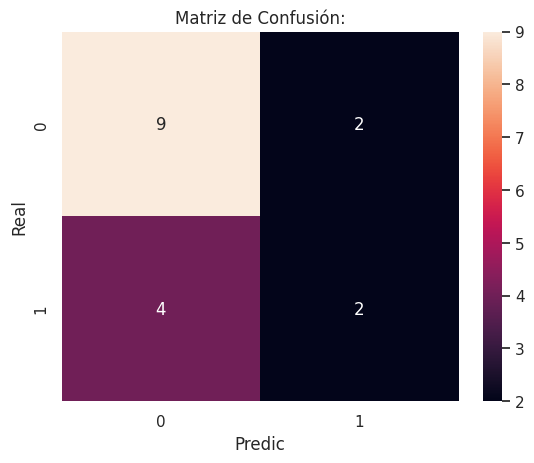

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.50      0.33      0.40         6

    accuracy                           0.65        17
   macro avg       0.60      0.58      0.58        17
weighted avg       0.62      0.65      0.63        17

 
 


In [ ]:
n_neighbors_range = list(range(2, 6))# List to store the average RMSE for each value of max_depth:
accuracy = []

for n_neighbor in n_neighbors_range:
    clf = KNeighborsClassifier(n_neighbors = n_neighbor ,
                              weights ='distance')
                              # weights = 'uniform'
    clf.fit(X_train, y_train)
# Veo el accuracy sobre el conjunto train
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
# Validación cruzada para serie temporal
    # kf = StratifiedKFold(n_splits=5) #este busca iterar teniendo en cuenta el desequilibrio en los datos
    kf = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring="accuracy")
    print("Metricas cross_validation", scores)
    print("Media de cross_validation", scores.mean())
# Prueba
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
#Matriz confusión y métricas
    print('N° Vecinos Cercanos',n_neighbor)
    # plt.figure(figsize=(12,12))
    sns.heatmap(matriz, annot=True)
    plt.title('Matriz de Confusión:'), plt.ylabel("Real"), plt.xlabel("Predic")
    plt.show()

    print(metrics.classification_report(y_test, y_pred))

    print(" ")
    print(" ")

**Métricas**

(Luego de entrenar nuestro modelo y habiendo decidido como métrica el Accuracy (el % de aciertos) obtenemos un 75% sobre el set de entrenamiento (y asumimos que ese porcentaje nos sirve para nuestro objetivo).)

Cuando hacemos el predict() sobre el conjunto de test y obtenemos las predicciones, las podemos comprobar y contrastar con los valores reales almacenados en y_test y hallar así la métrica que usamos. Los resultados que nos puede dar serán:

1. Si el accuracy en Test es "cercano" al de Entrenamiento (dijimos 75%) por ejemplo en este caso si estuviera entre 65 ú 85% quiere decir que nuestro modelo entrenado está generalizando bien y lo podemos dar por bueno (siempre y cuando estemos conformes con las métricas obtenidas).

2. Si el Accuracy en Test es muy distinto al de Entrenamiento tanto por encima como por debajo, nos da un 99% ó un 25% (lejano al 75%) entonces es un indicador de que nuestro modelo no ha entrenado bien y no nos sirve. De hecho este podría ser un indicador de Overfitting.
Para evaluar mejor el segundo caso, es donde aparece el “conjunto de Validación”.

Cuatro casos posibles para cada clase:

**Alta precision y alto recall:** el modelo maneja perfectamente esa clase

**Alta precision y bajo recall:** el modelo no detecta la clase muy bien, pero cuando lo hace es altamente confiable.

**Baja precisión y alto recall:** se detecta bien la clase pero también incluye muestras de otras clases.

**Baja precisión y bajo recall:** El modelo no logra clasificar la clase correctamente.

Cuando tenemos un dataset desbalanceado, suele ocurrir que obtenemos un alto valor de precisión en la clase Mayoritaria y un bajo recall en la clase Minoritaria

https://www.aprendemachinelearning.com/sets-de-entrenamiento-test-validacion-cruzada/

### **Conclusiones:**

Se realizó el mismo procedimiento entrenando el conjunto con X1=Ap-QBO, X2=Ap-Clusters_km, X3=Ap-Clusters_MS, X4=Ap-Clusters_DB y con y=NAO. Para número de vecinos cercanos de 2 a 5.
* Los resultados utilizando los Clusteres son notoriamente mejores que utilizando simplemente los datos de la QBO.
* Los resultados fueron iguales utilizando X2 y X3, esto se debe a que ambos clusters eran muy similiares, difiriendo en apenas un par de puntos.
* En todos los casos los mejores resultados se daban con número de vecinos cercanos igual a 2.
* Los mejore resultados fueron con X2 y X3, con:

acuracy: 0.6470588235294118

precision: 0.6244343891402715

recall 0.6470588235294118

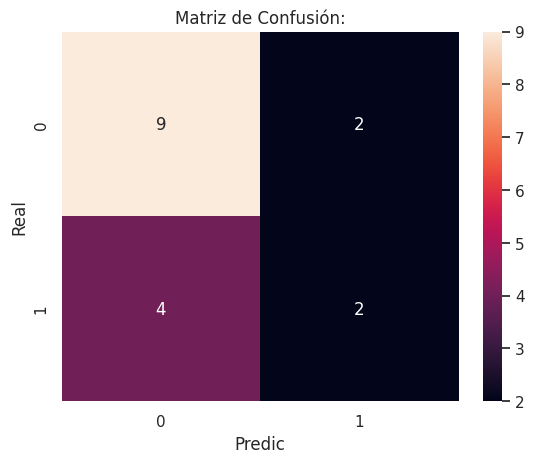

### Fases de la QBO

Ahora se investiga que tal funciona el algoritmo de vecinos cercanos para predecir la fase de la NAO, conociendo el valor del índice de act geomagnética Ap, para cada fase de la QBO por separado.

Primero se separa en 2 la base de datos, uno para QBO positiva (westerly) y otra con datos QBO negativa (easterly). Se controla si el número de datos está parejamente distribuido. Y luego se entrena el modelo para cada fase.

In [ ]:
invierno_qbo=invierno.copy()

invierno_qbo_e= invierno_qbo.loc[invierno_qbo['30hP QBO'] < 0]
invierno_qbo_w= invierno_qbo.loc[invierno_qbo['30hP QBO'] >  0]

In [ ]:
print (len(invierno_qbo))
print (len(invierno_qbo_e))
print (len(invierno_qbo_w))

67
33
33


In [ ]:
invierno_qbo_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 2 to 67
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YY            33 non-null     float64
 1   Ap            33 non-null     float64
 2   30hP QBO      33 non-null     float64
 3   NAO(C)        33 non-null     float64
 4   clusters_km2  33 non-null     int32  
 5   clusters_MS   33 non-null     int64  
 6   clusters_DB   33 non-null     int64  
 7   fase NAO      33 non-null     int64  
dtypes: float64(4), int32(1), int64(3)
memory usage: 2.2 KB


Westerly (+)

In [ ]:
X = invierno_qbo_w.iloc[:, [1]].values  #  La idea aquí es probar solo con la act geomagnética Ap
y = invierno_qbo_w.iloc[:, 7].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
clf = KNeighborsClassifier(n_neighbors =3,weights ='distance')
# weights = 'uniform' / weights = 'distance'
X1= clf.fit(X_train,y_train)

In [ ]:
#Obtengo el accuracy con el mismo conjunto de entrenamiento para saber si el modelo es bueno para estos datos
#(podría elegir otra métrica pero accuracy es bastante general)

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

y_train_pred = clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy en el conjunto de entrenamiento:", accuracy_train)

Accuracy en el conjunto de entrenamiento: 0.9166666666666666


In [ ]:
y_pred = clf.predict(X_test)

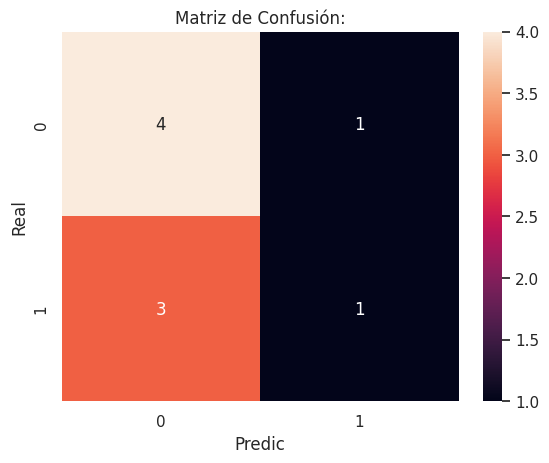

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.50      0.25      0.33         4

    accuracy                           0.56         9
   macro avg       0.54      0.53      0.50         9
weighted avg       0.54      0.56      0.52         9



In [ ]:
matriz = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz, annot=True)
plt.title('Matriz de Confusión:'), plt.ylabel("Real"), plt.xlabel("Predic")
plt.show()


print(metrics.classification_report(y_test, y_pred))

Easterly (-)

In [ ]:
X = invierno_qbo_e.iloc[:, [1]].values  #  La idea aquí es probar solo con la act geomagnética Ap
y = invierno_qbo_e.iloc[:, 7].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 3 ,weights ='distance')        #2 centros, sin motivo
# weights = 'uniform' / weights = 'distance'
X1= clf.fit(X_train,y_train)

In [ ]:
y_train_pred = clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Accuracy en el conjunto de entrenamiento:", accuracy_train)

Accuracy en el conjunto de entrenamiento: 1.0


In [ ]:
y_pred = clf.predict(X_test)

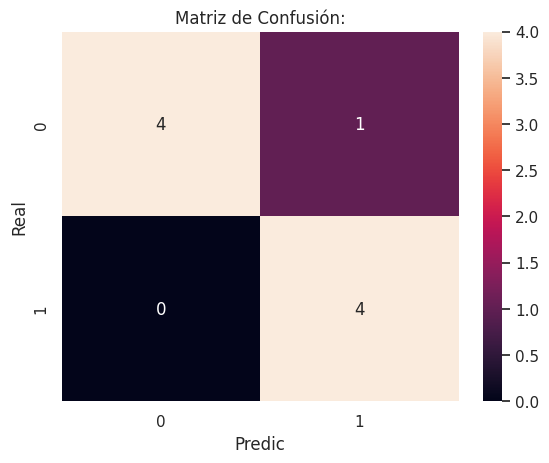

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.80      1.00      0.89         4

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9



In [ ]:
matriz = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz, annot=True)
plt.title('Matriz de Confusión:'), plt.ylabel("Real"), plt.xlabel("Predic")
plt.show()

print(metrics.classification_report(y_test, y_pred))

### **Conclusiones:**

El algoritmo de vecinos cercanos es más acertivo cuando la atmósfera está en fase aesterly, esto puede deberse a que hay una muy buena correlación entre la NAO y Ap en estas condiciones atmosféricas ecuatoriales.

-----------------------------------------------------------------------------

##4.4 Máquinas de Soporte Vectorial

In [ ]:
X = invierno.iloc[:, [1,4]].values  #  La idea es probar con los clusters o con la QBO, además del índice de act geomagnética Ap
#opciones: [1,2] o [1,4] o [1,5] 0 [1,6]
y = invierno.iloc[:, 7].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Accuracy en el conjunto de entrenamiento: 0.78
Kernel rbf
Matriz de Confusión


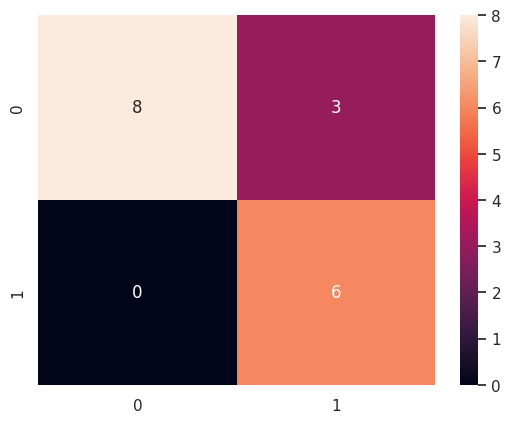

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.67      1.00      0.80         6

    accuracy                           0.82        17
   macro avg       0.83      0.86      0.82        17
weighted avg       0.88      0.82      0.83        17

 
 
Accuracy en el conjunto de entrenamiento: 0.78
Kernel linear
Matriz de Confusión


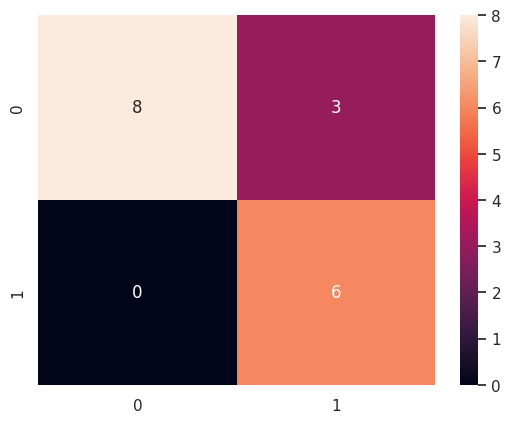

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.67      1.00      0.80         6

    accuracy                           0.82        17
   macro avg       0.83      0.86      0.82        17
weighted avg       0.88      0.82      0.83        17

 
 
Accuracy en el conjunto de entrenamiento: 0.78
Kernel sigmoid
Matriz de Confusión


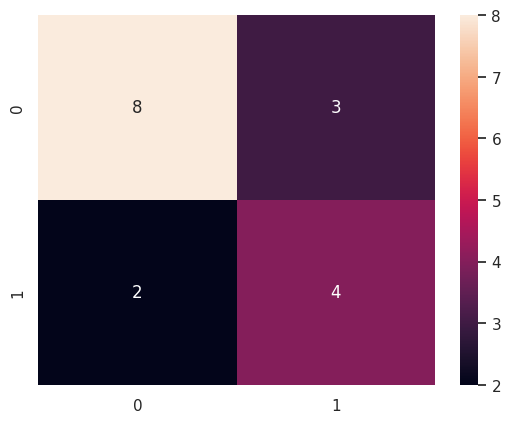

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.57      0.67      0.62         6

    accuracy                           0.71        17
   macro avg       0.69      0.70      0.69        17
weighted avg       0.72      0.71      0.71        17

 
 


In [ ]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

funcion = ["0", 'rbf', 'linear', 'sigmoid']


for i in range(1, 4):
    clf = svm.SVC(kernel=funcion[i])
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    print ("Kernel",funcion[i])
    print('Matriz de Confusión')
    sn.heatmap(matriz, annot=True)
    plt.show()

    print(metrics.classification_report(y_test, y_pred))

    print(" ")
    print(" ")

Accuracy en el conjunto de entrenamiento: 0.8
Polinomio de grado 3
Matriz de Confusión


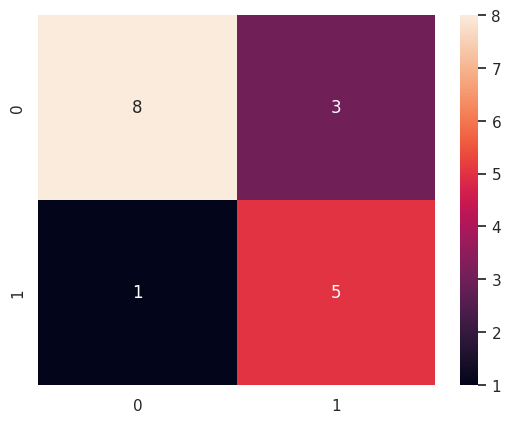

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.62      0.83      0.71         6

    accuracy                           0.76        17
   macro avg       0.76      0.78      0.76        17
weighted avg       0.80      0.76      0.77        17

 
 
Accuracy en el conjunto de entrenamiento: 0.82
Polinomio de grado 4
Matriz de Confusión


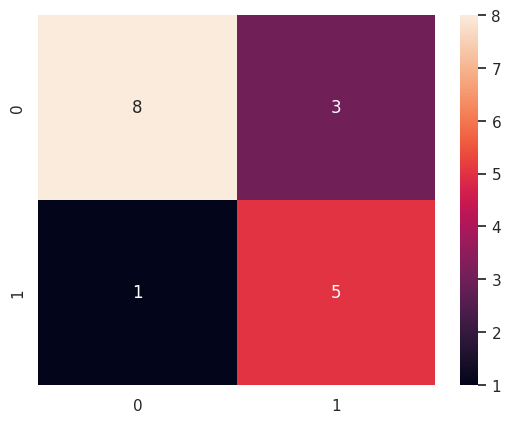

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.62      0.83      0.71         6

    accuracy                           0.76        17
   macro avg       0.76      0.78      0.76        17
weighted avg       0.80      0.76      0.77        17

 
 
Accuracy en el conjunto de entrenamiento: 0.82
Polinomio de grado 5
Matriz de Confusión


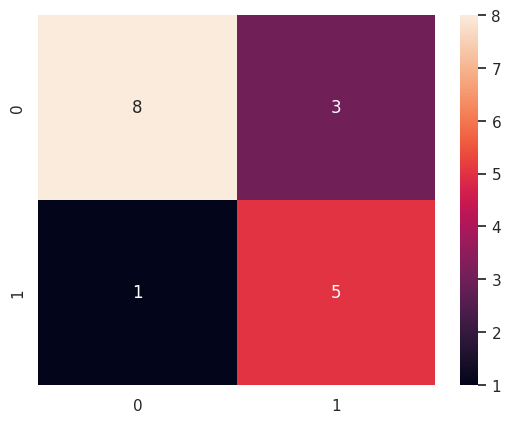

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.62      0.83      0.71         6

    accuracy                           0.76        17
   macro avg       0.76      0.78      0.76        17
weighted avg       0.80      0.76      0.77        17

 
 
Accuracy en el conjunto de entrenamiento: 0.82
Polinomio de grado 6
Matriz de Confusión


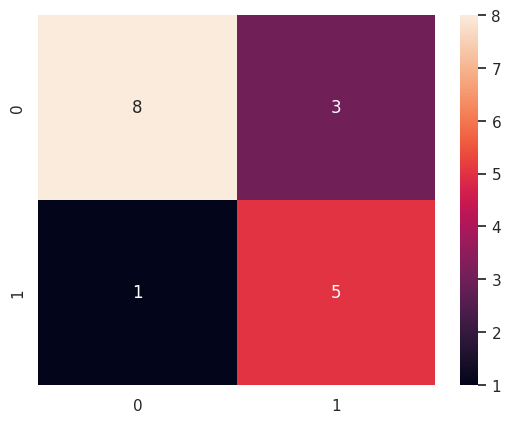

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.62      0.83      0.71         6

    accuracy                           0.76        17
   macro avg       0.76      0.78      0.76        17
weighted avg       0.80      0.76      0.77        17

 
 


In [ ]:
for i in range(3, 7):
    clf = svm.SVC(kernel='poly', degree=i)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    print ("Polinomio de grado", i)
    print('Matriz de Confusión')
    sn.heatmap(matriz, annot=True)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    print(" ")
    print(" ")

### **Conclusiones**

###Fases de la QBO

In [ ]:
#Divido por fase QBO

invierno_qbo=invierno.copy()

# invierno_qbo_e= invierno_qbo[invierno_qbo['QBO'] < 0]
# invierno_qbo_w= invierno_qbo[invierno_qbo['QBO'] >  0]

invierno_qbo_e= invierno.loc[invierno['30hP QBO'] < 0]
invierno_qbo_w= invierno.loc[invierno['30hP QBO'] >  0]

# Paso + a los easterly ya q hay algoritmos q no aceptan -
invierno_qbo_e['30hP QBO']=-1*invierno_qbo_e['30hP QBO']

<ipython-input-39-edd351c13bd0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invierno_qbo_e['30hP QBO']=-1*invierno_qbo_e['30hP QBO']


Westerly

In [ ]:
X = invierno_qbo_w.iloc[:, [1,2]].values
y = invierno_qbo_w.iloc[:, 7].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print("Todo el conjunto:", len(y)- y.sum(),"NAO+ / ", y.sum(),"NAO-")
print("Conjunto entrenamiento:", len(y_train)- y_train.sum(),"NAO+ / ", y_train.sum(),"NAO-")
print("Conjunto prueba:", len(y_test)- y_test.sum(),"NAO+ / ", y_test.sum(),"NAO-")

Todo el conjunto: 21 NAO+ /  12 NAO-
Conjunto entrenamiento: 16 NAO+ /  8 NAO-
Conjunto prueba: 5 NAO+ /  4 NAO-


Accuracy en el conjunto de entrenamiento: 0.6666666666666666
Kernel rbf
Matriz de Confusión


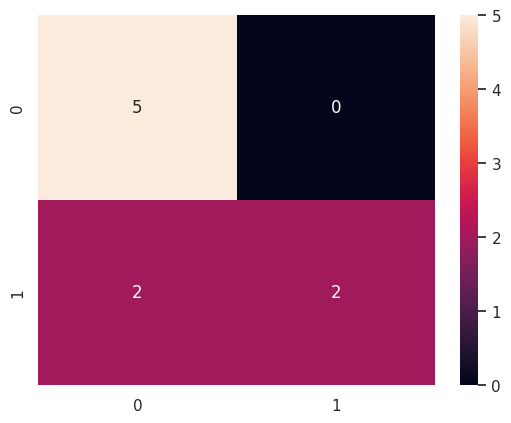

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9

 
 
Accuracy en el conjunto de entrenamiento: 0.6666666666666666
Kernel linear
Matriz de Confusión


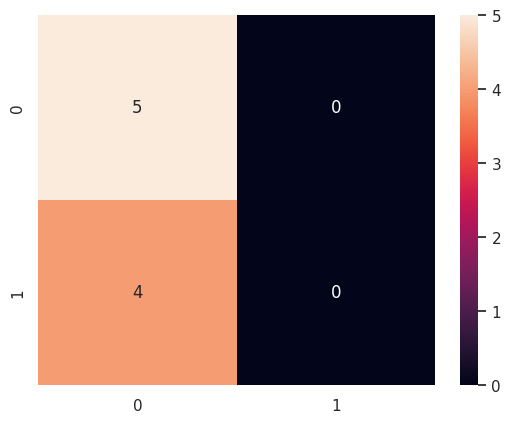

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

 
 
Accuracy en el conjunto de entrenamiento: 0.6666666666666666
Kernel sigmoid
Matriz de Confusión


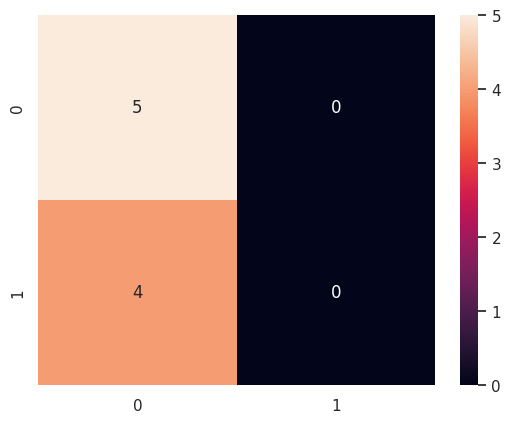

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

 
 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
funcion = ["0", 'rbf', 'linear', 'sigmoid']


for i in range(1, 4):
    clf = svm.SVC(kernel=funcion[i])
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    print ("Kernel",funcion[i])
    print('Matriz de Confusión')
    sn.heatmap(matriz, annot=True)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    print(" ")
    print(" ")

Accuracy en el conjunto de entrenamiento: 0.7083333333333334
Polinomio de grado 3
Matriz de Confusión


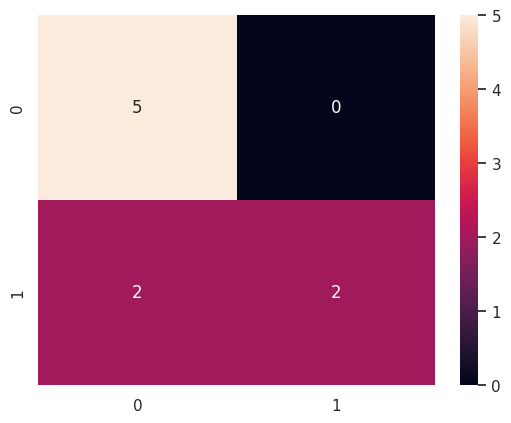

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9

 
 
Accuracy en el conjunto de entrenamiento: 0.7083333333333334
Polinomio de grado 4
Matriz de Confusión


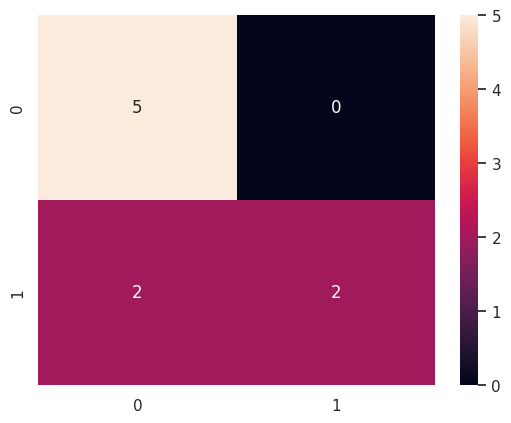

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9

 
 
Accuracy en el conjunto de entrenamiento: 0.7083333333333334
Polinomio de grado 5
Matriz de Confusión


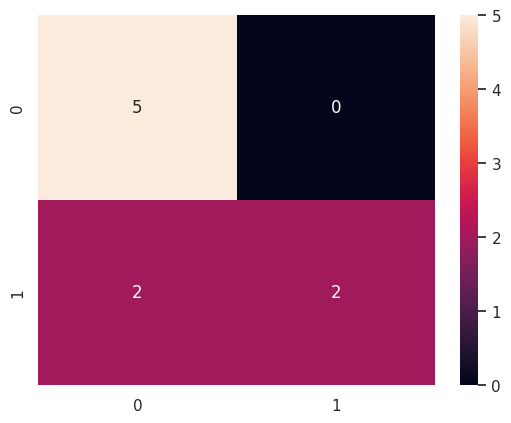

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9

 
 
Accuracy en el conjunto de entrenamiento: 0.7083333333333334
Polinomio de grado 6
Matriz de Confusión


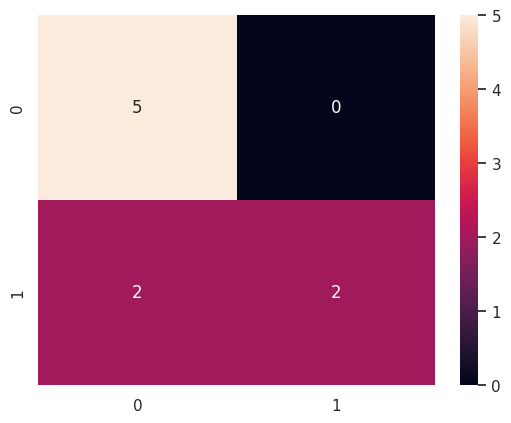

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.50      0.67         4

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9

 
 


In [ ]:
for i in range(3, 7):
    clf = svm.SVC(kernel='poly', degree=i)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    print ("Polinomio de grado", i)
    print('Matriz de Confusión')
    sn.heatmap(matriz, annot=True)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    print(" ")
    print(" ")

Easterly

In [ ]:
X = invierno_qbo_e.iloc[:, [1,2]].values
y = invierno_qbo_e.iloc[:, 7].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print("Todo el conjunto:", len(y)- y.sum(),"NAO+ / ", y.sum(),"NAO-")
print("Conjunto entrenamiento:", len(y_train)- y_train.sum(),"NAO+ / ", y_train.sum(),"NAO-")
print("Conjunto prueba:", len(y_test)- y_test.sum(),"NAO+ / ", y_test.sum(),"NAO-")

Todo el conjunto: 20 NAO+ /  13 NAO-
Conjunto entrenamiento: 15 NAO+ /  9 NAO-
Conjunto prueba: 5 NAO+ /  4 NAO-


Accuracy en el conjunto de entrenamiento: 0.625
Kernel rbf
Matriz de Confusión


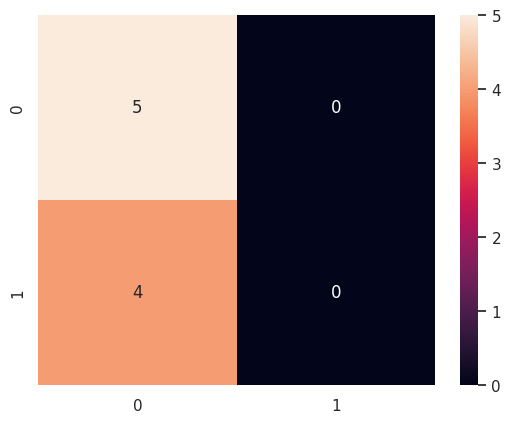

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

 
 
Accuracy en el conjunto de entrenamiento: 0.625
Kernel linear
Matriz de Confusión


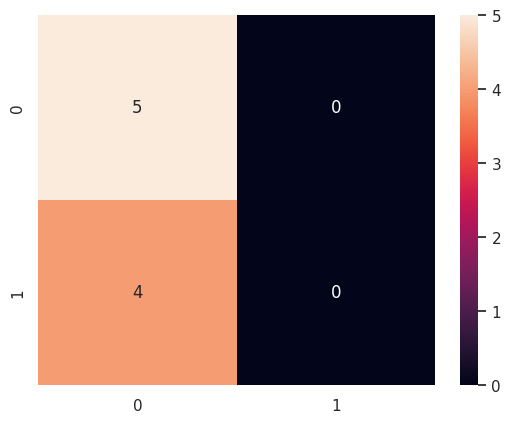

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

 
 
Accuracy en el conjunto de entrenamiento: 0.625
Kernel sigmoid
Matriz de Confusión


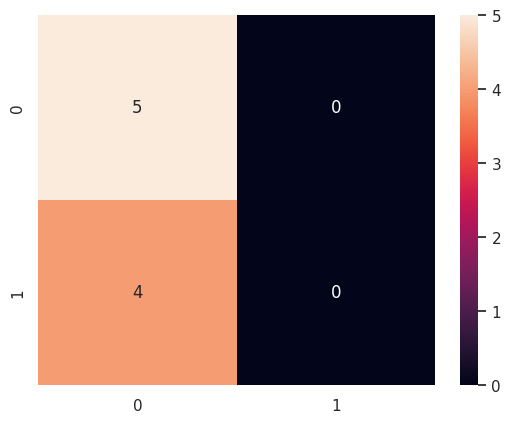

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

 
 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
funcion = ["0", 'rbf', 'linear', 'sigmoid']


for i in range(1, 4):
    clf = svm.SVC(kernel=funcion[i])
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    print ("Kernel",funcion[i])
    print('Matriz de Confusión')
    sn.heatmap(matriz, annot=True)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    print(" ")
    print(" ")

Accuracy en el conjunto de entrenamiento: 0.6666666666666666
Polinomio de grado 3
Matriz de Confusión


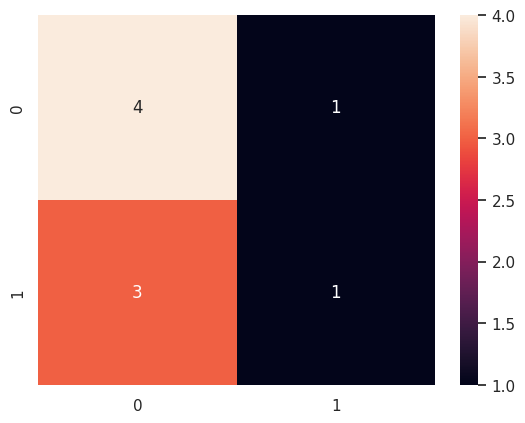

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.50      0.25      0.33         4

    accuracy                           0.56         9
   macro avg       0.54      0.53      0.50         9
weighted avg       0.54      0.56      0.52         9

 
 
Accuracy en el conjunto de entrenamiento: 0.6666666666666666
Polinomio de grado 4
Matriz de Confusión


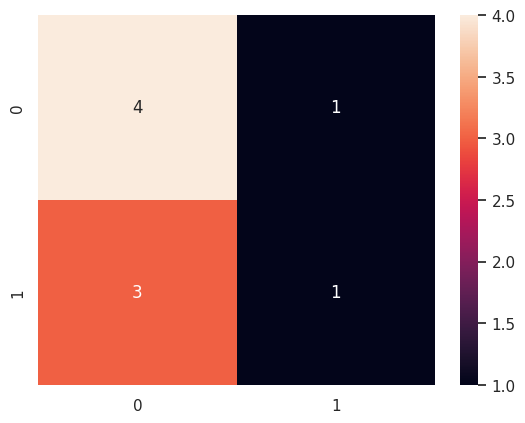

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.50      0.25      0.33         4

    accuracy                           0.56         9
   macro avg       0.54      0.53      0.50         9
weighted avg       0.54      0.56      0.52         9

 
 
Accuracy en el conjunto de entrenamiento: 0.7083333333333334
Polinomio de grado 5
Matriz de Confusión


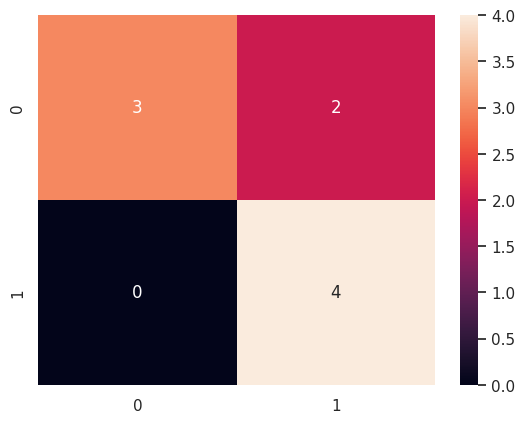

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.67      1.00      0.80         4

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.77         9
weighted avg       0.85      0.78      0.77         9

 
 
Accuracy en el conjunto de entrenamiento: 0.75
Polinomio de grado 6
Matriz de Confusión


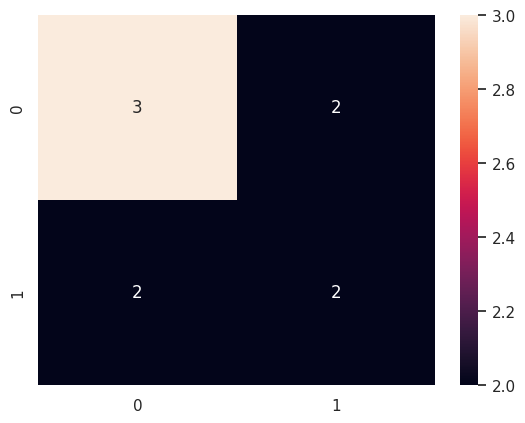

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.50      0.50      0.50         4

    accuracy                           0.56         9
   macro avg       0.55      0.55      0.55         9
weighted avg       0.56      0.56      0.56         9

 
 


In [ ]:
for i in range(3, 7):
    clf = svm.SVC(kernel='poly', degree=i)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Accuracy en el conjunto de entrenamiento:", accuracy_train)
    y_pred = clf.predict(X_test)
    matriz = confusion_matrix(y_test, y_pred)
    print ("Polinomio de grado", i)
    print('Matriz de Confusión')
    sn.heatmap(matriz, annot=True)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    print(" ")
    print(" ")

### **Conclusiones:**